In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from models import Network, LSTMWithEncoder
from data_preprocessing import DataPreprocessor, SimpleDataSet

torch.set_default_dtype(torch.float32)
%matplotlib inline

       Month  #Passengers
0 1949-01-01        112.0
1 1949-02-01        118.0
2 1949-03-01        132.0
3 1949-04-01        129.0
4 1949-05-01        121.0


<Axes: xlabel='Month'>

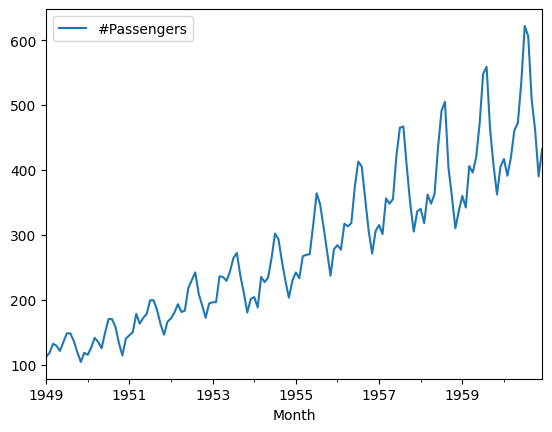

In [3]:
df = pd.read_csv("data/AirPassengers.csv", parse_dates=['Month'], dtype=np.float32)
print(df.head())
df.plot(x="Month", y='#Passengers')


In [4]:
n_ar = 5
n_hist = 3
batch_size = 1.0 # percentage
test_size = 0.3 # percentage\\
to_tensor = lambda x: [torch.tensor(i, dtype=torch.float32) for i in x]

U = []
Y = df["#Passengers"].values


def create_model_data(U, Y, n_ar=0, n_hist=0, n_b=0, n_hist_u=0, test_size=0.1):
    to_tensor = lambda x: [torch.tensor(i, dtype=torch.float32) for i in x]

    Xdata, Ydata, Hdata = DataPreprocessor.create_NARX_model(U, Y, n_ar=n_ar, n_b=n_b, return_history=True, n_hist_y=n_hist, n_hist_u=n_hist_u, output_as_tuple=False)
    Xdata, Ydata, Hdata = to_tensor([Xdata, Ydata, Hdata])
    Xtrain, Xval, Ytrain, Yval, Htrain, Hval = train_test_split(Xdata, Ydata, Hdata, test_size=test_size, shuffle=True)

    return Xtrain, Xval, Ytrain, Yval, Htrain, Hval, Xdata, Ydata, Hdata

def create_dataloaders(Xtrain, Xval, Ytrain, Yval, Htrain, Hval, batch_size=10):
    n_samples = len(Ytrain)
    n_batch = round(batch_size * n_samples)
    assert n_batch > 1, "Batch normalization of the model requires batch size greater than 1!"

    train_dl_net = DataLoader(SimpleDataSet(Xtrain, Ytrain), batch_size=n_batch, shuffle=True)
    train_dl_lstm = DataLoader(SimpleDataSet((Xtrain, Htrain), Ytrain), batch_size=n_batch, shuffle=True)
    val_dl_net = DataLoader(SimpleDataSet(Xval, Yval), batch_size=n_batch, shuffle=True)
    val_dl_lstm = DataLoader(SimpleDataSet((Xval, Hval), Yval), batch_size=n_batch, shuffle=True)

    return train_dl_net, train_dl_lstm, val_dl_net, val_dl_lstm

Xtrain, Xval, Ytrain, Yval, Htrain, Hval, Xdata, Ydata, Hdata = create_model_data(U, Y, n_ar, n_hist, n_b=0, n_hist_u=0, test_size=test_size)
train_dl_net, train_dl_lstm, val_dl_net, val_dl_lstm = create_dataloaders(Xtrain, Xval, Ytrain, Yval, Htrain, Hval, batch_size=batch_size)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model_lstm to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        if isinstance(X, torch.Tensor):
            pred = model(X)
        else:
            pred = model(*X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss = loss.item()
    return loss


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            if isinstance(X, torch.Tensor):
                pred = model(X)
            else:
                pred = model(*X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

def fit_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs = 1, log_interval = None):
    loss_train = []
    loss_val = []
    if not log_interval:
        log_interval = round(epochs * 0.1)
    for t in range(epochs):
        loss_t = train_loop(train_dataloader, model, loss_fn, optimizer)
        loss_v = test_loop(test_dataloader, model, loss_fn)
        loss_train.append(loss_t)
        loss_val.append(loss_v)

        if t % log_interval == 0:
            print(f"Epoch {t+1}, Train loss = {loss_t}, Test loss = {loss_v} \n-------------------------------")
    return loss_train, loss_val

In [6]:
train_dl_net.dataset[0][1]

tensor([194.])

In [7]:
# Create models
n_output = 1 if Ytrain.ndim == 1 else Ytrain.shape[-1]
model_net = Network([n_ar, 32, n_output])
model_lstm = LSTMWithEncoder(
    input_size=1,  # number of features in a time step --> input is univariate
    hidden_size=n_hist * 5,
    output_size=n_output,
    history_size=n_hist,
)
print(f"model structure - MLP: {model_net}\n\n")
print(f"model structure - LSTM: {model_lstm}\n\n")

loss_fn = nn.MSELoss()
optimizer_net = torch.optim.Adam(model_net.parameters())
optimizer_lstm = torch.optim.Adam(model_lstm.parameters())
epochs = 5001
loss_train = []
loss_val = []

loss_train_lstm, loss_val_lstm = fit_loop(train_dl_lstm, val_dl_lstm, model_lstm, loss_fn, optimizer_lstm, epochs)
loss_train_net, loss_val_net = fit_loop(train_dl_net, val_dl_net, model_net, loss_fn, optimizer_net, epochs)


model structure - MLP: Network(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=32, bias=True)
  )
  (batchnorm_layers): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lastlayer): Linear(in_features=32, out_features=1, bias=True)
)


model structure - LSTM: LSTMWithEncoder(
  (encoder): Network(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=40, bias=True)
    )
    (batchnorm_layers): ModuleList(
      (0): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (lastlayer): Linear(in_features=40, out_features=15, bias=True)
  )
  (lstm): LSTM(1, 15, batch_first=True)
  (h2o): Network(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=40, bias=True)
    )
    (batchnorm_layers): ModuleList(
      (0): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (lastlayer): Linear(in_features=40,

torch.Size([135, 1]) torch.Size([135, 1])


array([<Axes: xlabel='time index'>, <Axes: xlabel='Epochs'>], dtype=object)

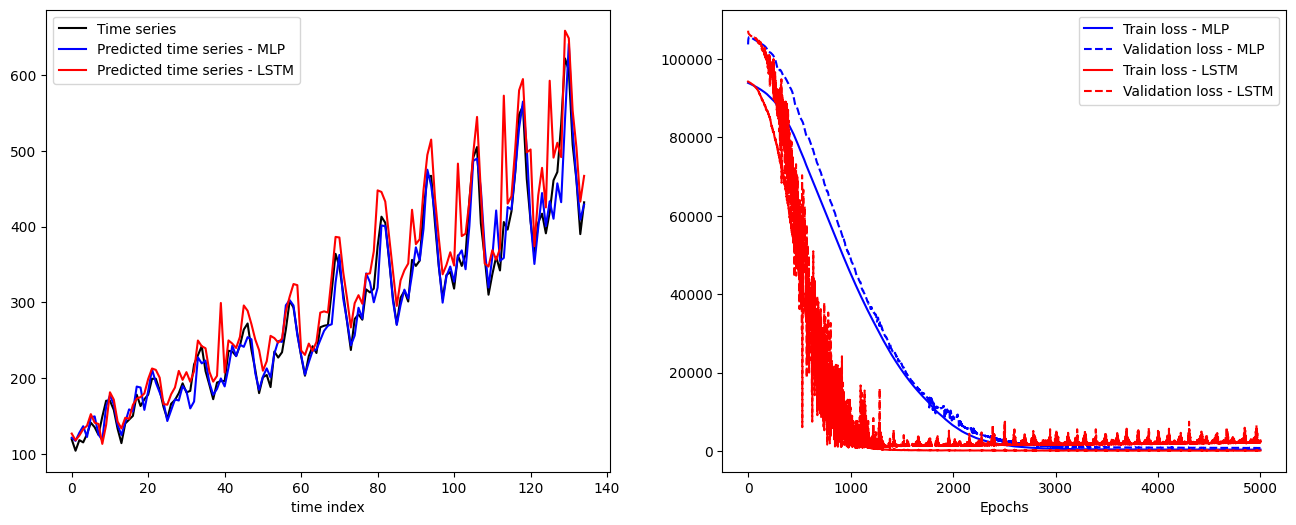

In [9]:
model_net.eval()
with torch.no_grad():
    y_pred_ts = model_net(Xdata)
    y_pred_lstm = model_lstm(Xdata, Hdata)

print(Ydata.shape, y_pred_ts.shape)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

def plot_results(axs, y_pred, loss_train, loss_val, model_name, color):
    # plot predicted result
    axs[0].plot(y_pred, label=f'Predicted time series - {model_name}', color=color)
    axs[0].set_xlabel('time index')
    axs[0].legend()

    axs[1].plot(np.array(loss_train), label=f'Train loss - {model_name}', color=color, linestyle='solid')
    axs[1].plot(np.array(loss_val), label=f'Validation loss - {model_name}', color=color, linestyle='dashed')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    return axs

# Plot true time series once
axs[0].plot(Ydata, color='k', label='Time series')

plot_results(axs, y_pred_ts, loss_train_net, loss_val_net, "MLP", color='b')
plot_results(axs, y_pred_lstm, loss_train_lstm, loss_val_lstm, "LSTM", color='r')
